<a href="https://colab.research.google.com/github/Niki2194/California_House_Pricing/blob/main/AI_use_case.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install openslide-bin

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 78.8 MB/s eta 0:00:00


In [ ]:
import openslide
import numpy as np
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import os
from skimage.filters import threshold_otsu

# Parameters
TILE_SIZE = 224  # input size for ResNet
STRIDE = 224     # non-overlapping tiles
THRESHOLD_EMPTY = 0.7  # threshold for empty tile (percent white)

# Paths to your SVS files
svs_files = {
    "b_cell": "/content/drive/MyDrive/AI Use Cases/B_cat_KBL_2011T54601.svs",
    "t_cell": "/content/drive/MyDrive/AI Use Cases/T_KTL_2005T52561.svs"
}

# Output directories for tiles
output_dir = "./tiles"
os.makedirs(output_dir, exist_ok=True)
for cls in svs_files.keys():
    os.makedirs(os.path.join(output_dir, cls), exist_ok=True)

def is_empty(tile, white_thresh=220, percent_thresh=THRESHOLD_EMPTY):
    gray = tile.convert("L")
    arr = np.array(gray)
    white_pixels = np.sum(arr > white_thresh)
    white_fraction = white_pixels / arr.size
    return white_fraction > percent_thresh

def extract_tiles(svs_path, label, save_dir):
    slide = openslide.OpenSlide(svs_path)
    w, h = slide.dimensions

    count = 0
    for y in range(0, h - TILE_SIZE, STRIDE):
        for x in range(0, w - TILE_SIZE, STRIDE):
            try:
                tile = slide.read_region((x, y), 0, (TILE_SIZE, TILE_SIZE)).convert("RGB")
            except openslide.OpenSlideError:
                print(f"Skipping tile at {(x, y)} - read error")
                continue
            if not is_empty(tile):
                # Remove metadata before saving
                clean_tile = Image.new("RGB", tile.size)
                clean_tile.paste(tile)
                clean_tile.save(os.path.join(save_dir, f"{label}_{count}.png"))
                count += 1
    slide.close()

# Extract tiles from both slides
for label, svs_path in svs_files.items():
    extract_tiles(svs_path, label, os.path.join(output_dir, label))

print("Tile extraction done.")


# Dataset class
class CellTilesDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform

        for label_idx, cls in enumerate(["b_cell", "t_cell"]):
            cls_dir = os.path.join(root_dir, cls)
            for fname in os.listdir(cls_dir):
                if fname.endswith(".png"):
                    self.samples.append((os.path.join(cls_dir, fname), label_idx))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = Image.open(path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Transforms for training
transform = transforms.Compose([
    transforms.Resize((TILE_SIZE, TILE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Imagenet stats
                         std=[0.229, 0.224, 0.225]),
])

# Load dataset
dataset = CellTilesDataset(output_dir, transform=transform)

# Split dataset into train/test (80/20)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

# Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet18(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, 2)  # 2 classes: b_cell, t_cell
model = model.to(device)

# Loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training loop
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    for imgs, labels in dataloader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
    return total_loss / len(dataloader.dataset), correct / len(dataloader.dataset)

def eval_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
    return total_loss / len(dataloader.dataset), correct / len(dataloader.dataset)


# Run training for a few epochs
num_epochs = 10
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
    test_loss, test_acc = eval_model(model, test_loader, criterion, device)
    print(f"Epoch {epoch+1}/{num_epochs}: Train loss={train_loss:.4f}, Train acc={train_acc:.4f}, Test loss={test_loss:.4f}, Test acc={test_acc:.4f}")

Tile extraction done.
Epoch 1/10: Train loss=0.0195, Train acc=0.9932, Test loss=0.0077, Test acc=0.9970
Epoch 2/10: Train loss=0.0065, Train acc=0.9978, Test loss=0.0074, Test acc=0.9970
Epoch 3/10: Train loss=0.0040, Train acc=0.9986, Test loss=0.0068, Test acc=0.9972
Epoch 4/10: Train loss=0.0050, Train acc=0.9984, Test loss=0.0078, Test acc=0.9970
Epoch 5/10: Train loss=0.0064, Train acc=0.9976, Test loss=0.1254, Test acc=0.9658
Epoch 6/10: Train loss=0.0036, Train acc=0.9987, Test loss=0.0050, Test acc=0.9976
Epoch 7/10: Train loss=0.0072, Train acc=0.9976, Test loss=0.0056, Test acc=0.9974
Epoch 8/10: Train loss=0.0039, Train acc=0.9985, Test loss=0.0063, Test acc=0.9972
Epoch 9/10: Train loss=0.0053, Train acc=0.9981, Test loss=0.0084, Test acc=0.9964
Epoch 10/10: Train loss=0.0030, Train acc=0.9989, Test loss=0.0087, Test acc=0.9962


In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, mean_absolute_error, mean_squared_error, jaccard_score
import torch.nn.functional as F

def compute_metrics(model, dataloader, device):
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            probs = F.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())  # Probability of class 1 (t_cell)
            all_labels.extend(labels.cpu().numpy())

    # Convert to numpy
    y_true = np.array(all_labels)
    y_pred = np.array(all_preds)
    y_prob = np.array(all_probs)

    # Metrics
    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    f1 = f1_score(y_true, y_pred)
    mad = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    iou = jaccard_score(y_true, y_pred)

    print(f"Accuracy:     {acc:.4f}")
    print(f"AUC:          {auc:.4f}")
    print(f"F1 Score:     {f1:.4f}")
    print(f"MAD:          {mad:.4f}")
    print(f"MSE:          {mse:.4f}")
    print(f"IoU (Jaccard):{iou:.4f}")

    return {
        "accuracy": acc,
        "auc": auc,
        "f1": f1,
        "mad": mad,
        "mse": mse,
        "iou": iou
    }

In [ ]:
metrics = compute_metrics(model, test_loader, device)

Accuracy:     0.9962
AUC:          0.9999
F1 Score:     0.9951
MAD:          0.0038
MSE:          0.0038
IoU (Jaccard):0.9903


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_metrics(metrics):
    # Set plot style
    sns.set(style="whitegrid")

    # Prepare data
    metric_names = list(metrics.keys())
    metric_values = list(metrics.values())

    # Create bar plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x=metric_names, y=metric_values, palette="viridis")

    plt.title("Model Performance Metrics")
    plt.ylim(0, 1)
    for i, val in enumerate(metric_values):
        plt.text(i, val + 0.02, f"{val:.2f}", ha='center', va='bottom', fontsize=10)

    plt.ylabel("Score")
    plt.xlabel("Metric")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Accuracy:     0.9962
AUC:          0.9999
F1 Score:     0.9951
MAD:          0.0038
MSE:          0.0038
IoU (Jaccard):0.9903


/tmp/ipython-input-9-1244018711.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metric_names, y=metric_values, palette="viridis")


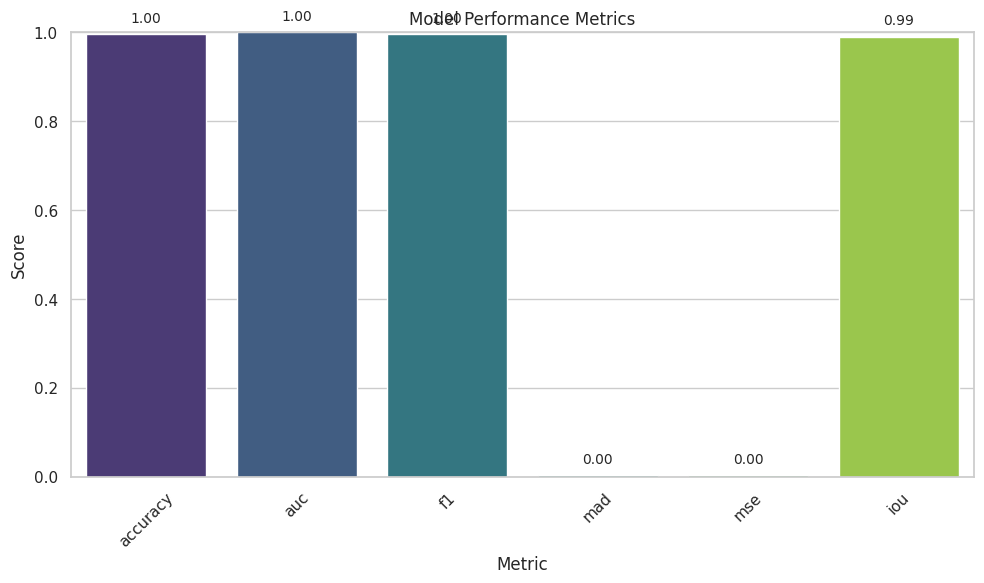

In [ ]:
metrics = compute_metrics(model, test_loader, device)
plot_metrics(metrics)

In [ ]:
!rm -rf ./tiles/*